# Library Import

In [1]:
import yfinance as yf
from datetime import datetime
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import FinanceDataReader as fdr

# Get NASDAQ Finance List

In [2]:
# 'KRX', 'KOSPI', 'KOSDAQ', 'KONEX', 'KRX-MARCAP', 'KRX-DESC', 'KOSPI-DESC', 'KOSDAQ-DESC', 'KONEX-DESC','NASDAQ', 'NYSE', 'AMEX', 'SSE', 'SZSE', 'HKEX', 'TSE', 'HOSE','S&P500','KRX-DELISTING', 'KRX-ADMINISTRATIVE', 'KRX-MARCAP','ETF/KR'

nasdaq_list = fdr.StockListing("NASDAQ")['Symbol']
nasdaq_list = nasdaq_list
print(nasdaq_list)

100%|██████████| 3691/3691 [00:03<00:00, 1041.22it/s]

0        AAPL
1        NVDA
2        MSFT
3        AMZN
4        META
        ...  
3686    FSHPR
3687    EURKR
3688    DTSQR
3689    NEWTH
3690     SFHG
Name: Symbol, Length: 3691, dtype: object


# Handle DataFrame

In [3]:
def handle_dataframe(data):
    ## 오늘 종가대비 내일 종가 상승, 하락 열
    data['Label'] = data['Adj Close'].shift(-1)
    data['Label'] = data['Label'].combine(data['Adj Close'], lambda x, y: 1 if x > y else -1)

    ## 거래량 변화량 열
    data['Volume Change'] = data['Volume'].pct_change()
    data['Volume Change'] = round(np.exp(data['Volume Change']), 3)

    ## 시가 변화량 열
    data['Open Change'] = round(((data['Open'] - data['Adj Close'].shift(1)) / data['Adj Close'].shift(1)) * 100, 3)

    ## 고가 변화량 열
    data['High Change'] = round(((data['High'] - data['High'].shift(1)) / data['High'].shift(1)) * 100, 3)

    ## 저가 변화량 열
    data['Low Change'] = round(((data['Low'] - data['Low'].shift(1)) / data['Low'].shift(1)) * 100, 3)

    data = data.dropna()
    data = data.iloc[1:61]
    # print(data.head())

    # change_ratio = data['Label'].value_counts(normalize=True) * 100
    
    return data


# Get YFinance Data

In [4]:
today = datetime.now().strftime("%Y-%m-%d")

# STOCK_NAME = 'META'
START_DAY = '1900-01-01'
END_DAY = today
INTERVAL = '1d'

data_name_list = []
data_list = []

for nasdaq in nasdaq_list:
    try:
        data = yf.download(nasdaq, START_DAY, END_DAY, INTERVAL)
        data = handle_dataframe(data)
        data.index = [f'{idx.date()}_{nasdaq}' for idx in data.index]
        
        # print(f'[{nasdaq}] Success!')
        
        data_name_list.append(nasdaq)
        data_list.append(data)
        
    except:
        print(f'{nasdaq} Not Found!')

data = pd.concat(data_list)
# print(data)
print(f'Sum Of Finanace : {len(data_name_list)}, Length Of DataFrame : {len(data)}')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Sum Of Finanace : 3691, Length Of DataFrame : 214593


C:\Users\furence\AppData\Local\Temp\ipykernel_5960\449132897.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(data_list)


## DataFrame Clustering

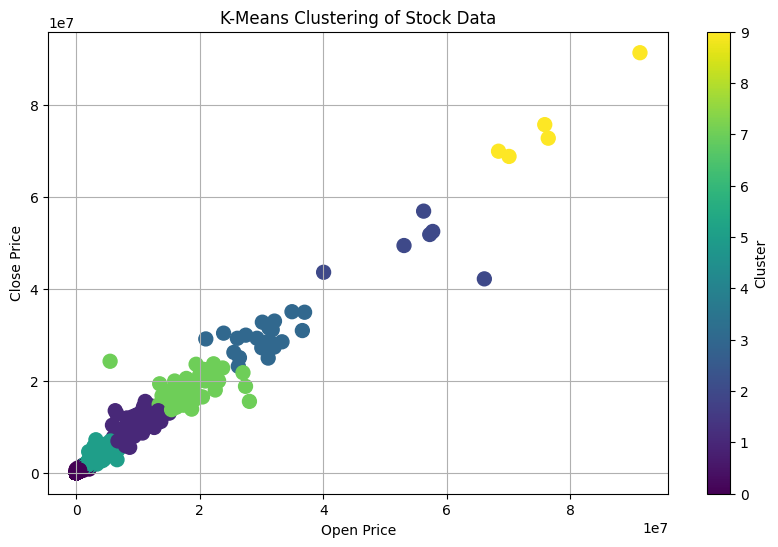

In [5]:
def dataframe_clustering(data, n_clusters=10):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])

    kmeans = KMeans(n_clusters, random_state=42)
    data['Cluster'] = kmeans.fit_predict(scaled_data)

    centers = kmeans.cluster_centers_
    distances = np.linalg.norm(scaled_data[:, np.newaxis] - centers, axis=2)
    data['Cluster Distance'] = distances[np.arange(len(distances)), data['Cluster']]
    data['Cluster Proba'] = round(1 / (1 + data['Cluster Distance']), 3)      # 거리가 작을 수록 소속도가 높음.
    data = data.drop(columns=['Cluster Distance'])

    plt.figure(figsize=(10, 6))
    plt.scatter(data['Open'], data['Close'], c=data['Cluster'], cmap='viridis', s=100)
    plt.title('K-Means Clustering of Stock Data')
    plt.xlabel('Open Price')
    plt.ylabel('Close Price')
    plt.colorbar(label='Cluster')
    plt.grid()
    plt.show()
    
dataframe_clustering(data)


## Make Graph

In [6]:
G = nx.DiGraph()        # 방향 엣지
# G = nx.Graph()        # 단방향 엣지

## 베이스 노드 만들기
# G.add_node("A", age=25, gender="M")
G.add_node("Up")
G.add_node("Down")

## 인덱스 노드 만들기
for index in data.index.astype(str):
    OC = data.loc[index, 'Open Change']
    HC = data.loc[index, 'High Change']
    LC = data.loc[index, 'Low Change']
    G.add_node(f'{index}', OC = OC, HC = HC, LC = LC)
    
## 클러스터 노드 만들기
for index in data.index.astype(str):
    CLUSTER = data.loc[index, 'Cluster']
    G.add_node(f'Clust_{int(CLUSTER)}')
    
## 인덱스 노드 -> 베이스 노드 엣지 연결
for index in data.index.astype(str):
    label = data.loc[index, 'Label']
    if label == 1:
        G.add_edge(f'{index}', 'Up')
    else:
        G.add_edge(f'{index}', 'Down')

## 전 날 인덱스 노드 -> 오늘 인덱스 노드 엣지 연결
cnt = 1
pre_index = ''
for index in data.index.astype(str):
    if cnt == 1:
        pre_index = index
        cnt += 1
    else:
        if pre_index[11:] == index[11:]:
            G.add_edge(f'{pre_index}', f'{index}', weight = data.loc[index, 'Volume Change'])
            pre_index = index
        else:
            pre_index = index

## 인덱스 노드 -> 클러스터 노드 연결
for index in data.index.astype(str):
    CLUSTER = data.loc[index, 'Cluster']
    G.add_edge(f'{index}', f'Clust_{int(CLUSTER)}', weight = data.loc[index, 'Cluster Proba'])

# # 노드 정보 출력
# print("노드 정보:")
# for node in G.nodes(data=True):
#     print(node)

# # 엣지 정보 출력
# print("\n엣지 정보:")
# for edge in G.edges(data=True):
#     print(edge)

nx.write_graphml(G, "Financial_Graph.graphml")
# G_loaded = nx.read_graphml("Financial_Graph.graphml")

## 2D Visualization

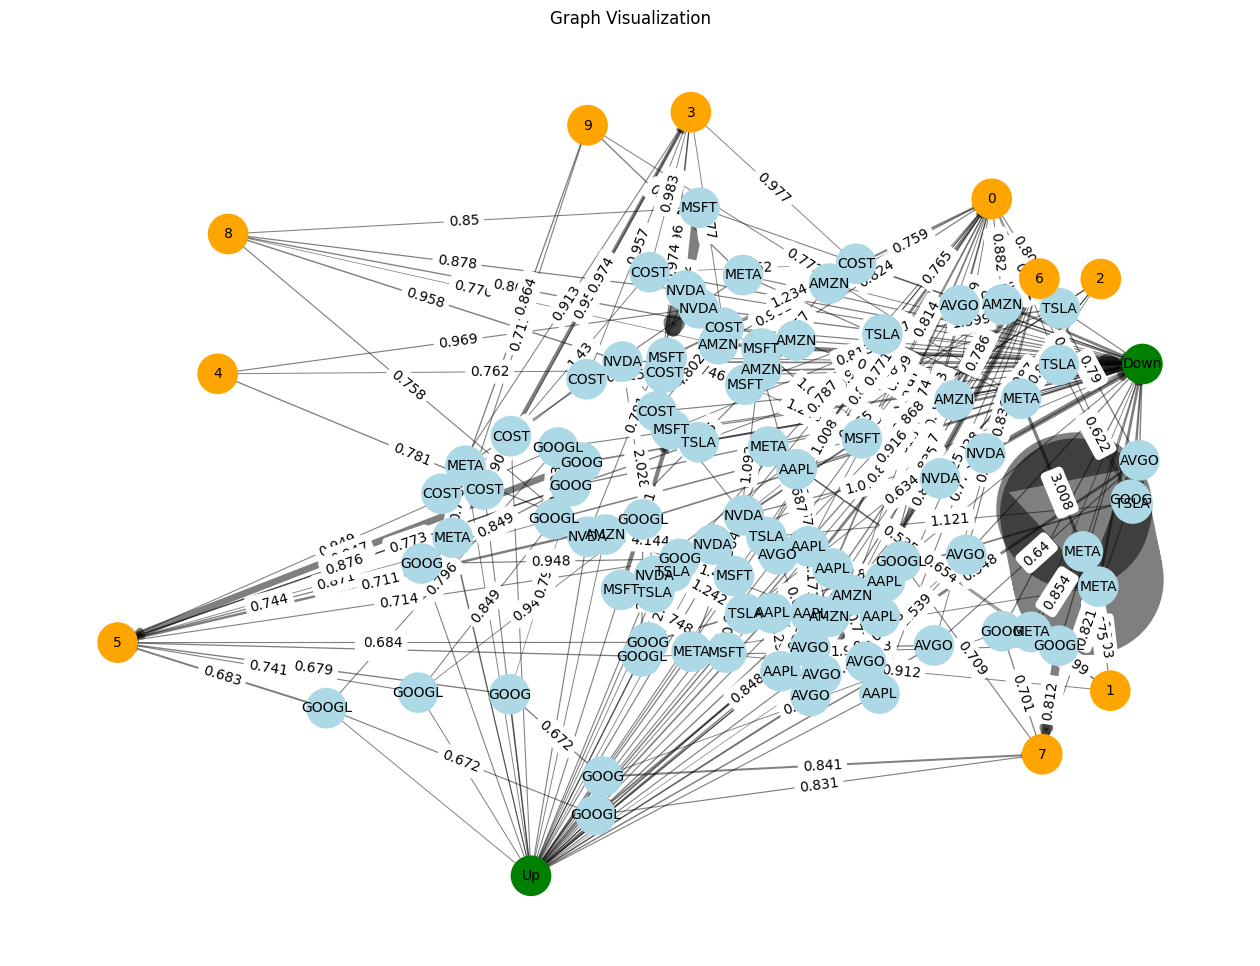

In [35]:
# 그래프 시각화
plt.figure(figsize=(16, 12))  # 그래프 크기 조정
pos = nx.spring_layout(G, k=0.5, iterations=50)  # 노드의 위치 결정, k값 조정하여 간격 증가
weights = nx.get_edge_attributes(G, 'weight')  # 엣지의 가중치 가져오기

# 노드 색상 설정
node_colors = [
    'green' if node in ['Up', 'Down'] else
    'orange' if 'Clust' in node else
    'lightblue'
    for node in G.nodes()
]

def clean_node_name(node_name):
    return node_name.split('_')[-1] if '_' in node_name else node_name

# 노드 그리기
nx.draw_networkx_nodes(G, pos, node_size=800, node_color=node_colors)
nx.draw_networkx_labels(G, pos, font_size=10,
                         labels={node: clean_node_name(node) for node in G.nodes()})

# 엣지 그리기
nx.draw_networkx_edges(G, pos, width=list(weights.values()), alpha=0.5)

# 가중치 레이블 추가
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Graph Visualization")
plt.axis('off')  # 축 숨기기
plt.show()

In [7]:
plt.figure(figsize=(16, 12))  # 그래프 크기 조정
pos = nx.spring_layout(G, k=0.5, iterations=50)  # 노드의 위치 결정
weights = nx.get_edge_attributes(G, 'weight')  # 엣지의 가중치 가져오기

# 노드 색상 설정
node_colors = [
    'green' if node in ['Up', 'Down'] else
    'orange' if 'Clust' in node else
    'lightblue'
    for node in G.nodes()
]

def clean_node_name(node_name):
    return node_name.split('_')[-1] if '_' in node_name else node_name

# 노드 그리기
nx.draw_networkx_nodes(G, pos, node_size=800, node_color=node_colors)
nx.draw_networkx_labels(G, pos, font_size=10,
                         labels={node: clean_node_name(node) for node in G.nodes()})

# 엣지 그리기
nx.draw_networkx_edges(G, pos, width=list(weights.values()), alpha=0.5)

# 가중치 레이블 추가
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Graph Visualization")
plt.axis('off')  # 축 숨기기

# 그래프를 벡터 파일로 저장 (SVG 또는 PDF)
plt.savefig("graph_visualization.svg", format='svg', bbox_inches='tight')  # SVG 형식으로 저장
# plt.savefig("graph_visualization.pdf", format='pdf', bbox_inches='tight')  # PDF 형식으로 저장

plt.close()  # 그래프 닫기

c:\Users\furence\anaconda3\envs\personal\lib\site-packages\scipy\sparse\_sputils.py:142: RuntimeWarning: overflow encountered in cast
  data = np.array(obj, dtype=dtype, copy=copy)
c:\Users\furence\anaconda3\envs\personal\lib\site-packages\networkx\drawing\layout.py:624: RuntimeWarning: overflow encountered in divide
  delta * (k * k / distance**2 - Ai * distance / k)
c:\Users\furence\anaconda3\envs\personal\lib\site-packages\networkx\drawing\layout.py:629: RuntimeWarning: invalid value encountered in divide
  delta_pos = (displacement * t / length).T
c:\Users\furence\anaconda3\envs\personal\lib\site-packages\networkx\drawing\layout.py:609: RuntimeWarning: invalid value encountered in multiply
  displacement *= 0


KeyboardInterrupt: 

<Figure size 1600x1200 with 0 Axes>

## 3D Visualization

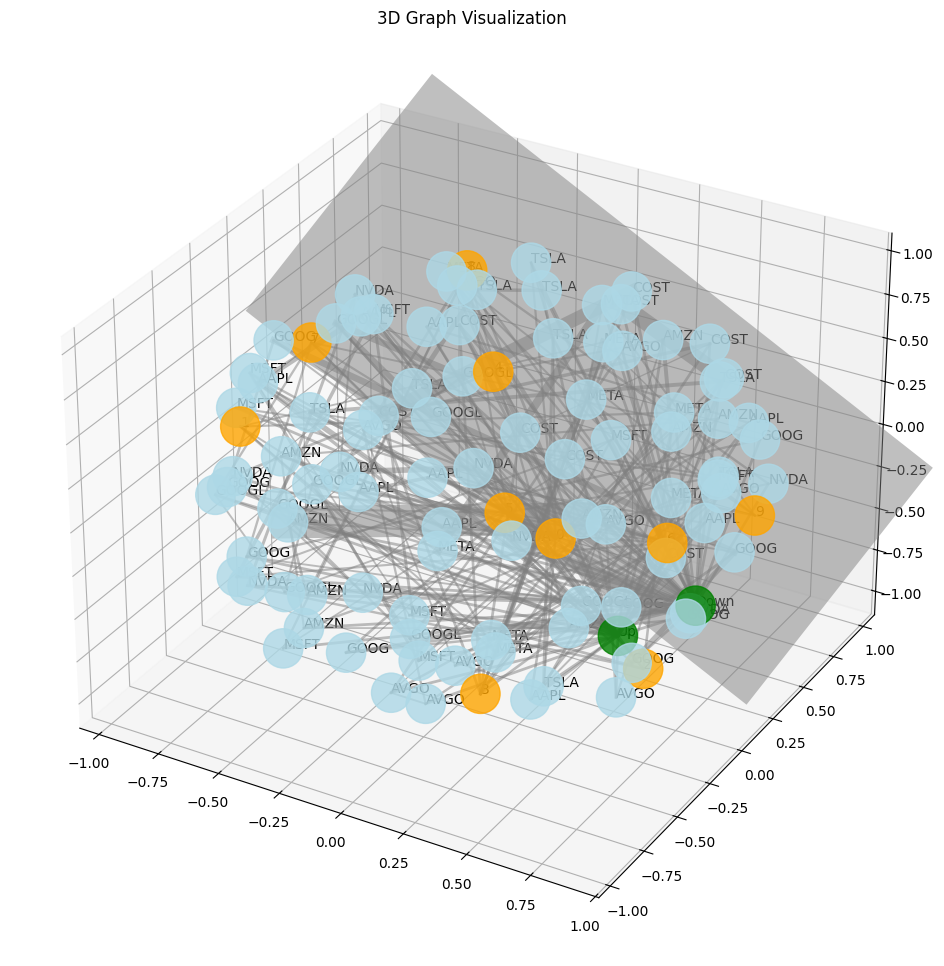

In [37]:
# 3D 그래프 시각화
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# 3D 위치 결정 (k 값을 늘려서 간격 증가)
pos = nx.spring_layout(G, dim=3, k=5.0, iterations=50)  # k를 1.0으로 증가
weights = nx.get_edge_attributes(G, 'weight')  # 엣지의 가중치 가져오기

# 노드 색상 설정
node_colors = [
    'green' if node in ['Up', 'Down'] else
    'orange' if 'Clust' in node else
    'lightblue'
    for node in G.nodes()
]

# 노드 그리기
x = [pos[node][0] for node in G.nodes()]
y = [pos[node][1] for node in G.nodes()]
z = [pos[node][2] for node in G.nodes()]

ax.scatter(x, y, z, s=800, c=node_colors, alpha=0.8)

# 노드 레이블 추가
for node in G.nodes():
    ax.text(pos[node][0], pos[node][1], pos[node][2], clean_node_name(node), size=10, zorder=1)

# 엣지 그리기
for edge in G.edges():
    x_edges = [pos[edge[0]][0], pos[edge[1]][0]]
    y_edges = [pos[edge[0]][1], pos[edge[1]][1]]
    z_edges = [pos[edge[0]][2], pos[edge[1]][2]]
    # 가중치를 안전하게 가져오기 위해 weights.get 사용
    weight = weights.get(edge, 1)  # 기본 가중치 1로 설정
    ax.plot(x_edges, y_edges, z_edges, color='gray', alpha=0.5, linewidth=weight * 2)

plt.title("3D Graph Visualization")
plt.show()